In [1]:
#Import the required libraries
import os
import cv2
from qiskit import *
import numpy as np
from qiskit.providers.ibmq import IBMQ
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection,datasets
from sklearn.model_selection import train_test_split
get_ipython().run_line_magic('matplotlib', 'inline')


In [2]:
#Empty the directory
def empty_folder(folder_path):
    
    # Iterate over the files 
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        os.remove(file_path)


In [3]:
#Check for unhealthy patches
def check_unhealthy(patch):
    # Count the number of pixels with a value greater than 150
    count = (patch > 150).sum()

    # Check if the count is greater than 20
    if count > 20:
        return 1
    else:
        return 0


In [4]:
def extract_overlapping_green_patches(image_path,annot_path, patch_size, stride, healthy_folderpath, unhealthy_folderpath):
    image = cv2.imread(image_path)
    annot = cv2.imread(annot_path)
    height, width, _ = image.shape
    patch_width, patch_height = patch_size
    stride_width, stride_height = stride
    
    if not os.path.exists(healthy_folderpath):
        os.makedirs(healthy_folderpath)
    if not os.path.exists(unhealthy_folderpath):
        os.makedirs(unhealthy_folderpath)   
        
    unhealthy_count = healthy_count = 0 # Initializing counter variables
    image_name = image_path.split('\\')[-1]
    print(f"Image : {image_name}")

    # Generate and separate patches
    for x in range(400, width - patch_width + 1 - 250, stride_width):
        for y in range(200, height - patch_height + 1 - 200, stride_height):
            if(unhealthy_count >= 500 and healthy_count >= 500): 
                return
            
            patch_image = image[y:y+patch_height, x:x+patch_width]
            patch_annot = annot[y:y+patch_height, x:x+patch_width]
            
            # Extract the green channel
            green_channel = patch_image[:, :, 1]
            # Replace the patch_image with its green channel
            patch_image = cv2.merge([green_channel, green_channel, green_channel])
            
            if(check_unhealthy(patch_annot)):
                if(unhealthy_count >= 500):
                    continue
                patch_path = os.path.join(unhealthy_folderpath, f"green_{image_name}_{y}_{x}.jpg")
                cv2.imwrite(patch_path, patch_image)
                unhealthy_count+=1
            else:
                if(healthy_count >= 500):
                    continue
                patch_path = os.path.join(healthy_folderpath, f"green_{image_name}_{y}_{x}.jpg")
                cv2.imwrite(patch_path, patch_image)
                healthy_count+=1
            if(patch_image.size == 0):
                print("Error in : ",patch_path)
    print("Healthy patches = ", healthy_count, " Unhealthy patches = ", unhealthy_count)    


In [6]:
# Train dataset patch extraction

train_healthy_folder = r"E:\E-Ophtha\Train\Green_Healthy_Patch_Train"
train_unhealthy_folder = r"E:\E-Ophtha\Train\Green_Unhealthy_Patch_Train"
patch_size = (16, 16)  # Width and height of each patch
stride = (3, 3)  # Stride for overlapping patches

# Empty the healthy and unhealthy folders
empty_folder(train_healthy_folder)
empty_folder(train_unhealthy_folder)

# Define the paths to the image and annotation folders
image_folder = r"E:\E-Ophtha\EX_Image_Train"
annot_folder = r"E:\E-Ophtha\EX_Annotation_Train"

# Get a list of file names in both folders
image_files = sorted(os.listdir(image_folder))
annot_files = sorted(os.listdir(annot_folder))

# Iterate over the files in both image and annotation folders simultaneously
for image_file, annot_file in zip(image_files, annot_files):
    image_path = os.path.join(image_folder, image_file)
    annot_path = os.path.join(annot_folder, annot_file)
    #Extract green channel patches 
    extract_overlapping_green_patches(image_path,annot_path, patch_size, stride, train_healthy_folder, train_unhealthy_folder)


Image : C0014792.jpg
Image : C0030692.jpg
Image : DS000U30.JPG
Image : DS000U32.JPG


In [7]:
# Test dataset patch extraction

test_healthy_folder = r"E:\E-Ophtha\Test\Green_Healthy_Patch_Test"
test_unhealthy_folder = r"E:\E-Ophtha\Test\Green_Unhealthy_Patch_Test"
patch_size = (16, 16)  # Width and height of each patch
stride = (3, 3)  # Stride for overlapping patches

# Empty the healthy and unhealthy folders
empty_folder(test_healthy_folder)
empty_folder(test_unhealthy_folder)

# Define the paths to the image and annotation folders
image_folder = r"E:\E-Ophtha\EX_Image_Test"
annot_folder = r"E:\E-Ophtha\EX_Annotation_Test"

# Get a list of file names in both folders
image_files = sorted(os.listdir(image_folder))
annot_files = sorted(os.listdir(annot_folder))

# Iterate over the files in both image and annotation folders simultaneously
for image_file, annot_file in zip(image_files, annot_files):
    image_path = os.path.join(image_folder, image_file)
    annot_path = os.path.join(annot_folder, annot_file)
    #Extract green channel patches 
    extract_overlapping_green_patches(image_path,annot_path, patch_size, stride, test_healthy_folder, test_unhealthy_folder)


Image : C0024407.jpg
Image : DS000GIU.JPG


In [4]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image_data_generator function
def image_data_generator(healthy_folder, unhealthy_folder):
    
    # Create an empty list to store the DataFrame objects
    dfs = []

    # Iterate over the healthy folder and add file paths and labels to the DataFrame
    for filename in os.listdir(healthy_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            filepath = os.path.join(healthy_folder, filename)
            df = pd.DataFrame({'filepath': [filepath], 'label': ['1']})
            dfs.append(df)

    # Iterate over the unhealthy folder and add file paths and labels to the DataFrame
    for filename in os.listdir(unhealthy_folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            filepath = os.path.join(unhealthy_folder, filename)
            df = pd.DataFrame({'filepath': [filepath], 'label': ['0']})
            dfs.append(df)

    # Concatenate the DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)
    df = df.sample(frac=1, random_state=42)
    # Create an ImageDataGenerator to load and preprocess the images
    datagen = ImageDataGenerator(rescale=1./255)

    # Set the batch size and target size
    batch_size = 10
    target_size = (16, 16)

    # Load the images from the DataFrame using flow_from_dataframe
    data = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filepath',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='binary',
        shuffle= False
    )
    return data, df


In [5]:
# Create model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout

model = tf.keras.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(16, 16, 1)))# leaky
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))
#model.add(Dropout(.3, noise_shape=None, seed=None)) #to prevent overfitting

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 4)           2308      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 4)          0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 4)          0         
 2D)                                                             
                                                        

In [6]:
# Plot curve function
import matplotlib.pyplot as plt

def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""

    # Adjust epochs and history data if they have different lengths
    if len(epochs) != hist.shape[0]:
        epochs = range(1, hist.shape[0] + 1)

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [7]:
# Generate train and test flatten layer output

# Set the paths to the train image folders
healthy_folder = r"E:\E-Ophtha\Train\Green_Healthy_Patch_Train"
unhealthy_folder = r"E:\E-Ophtha\Train\Green_Unhealthy_Patch_Train"

train_data, train_df = image_data_generator(healthy_folder, unhealthy_folder)
flatten_output_train = model.predict(train_data)

# Print the shape of the flatten layer's output
print("Train flatten output shape:", flatten_output_train.shape)

# Set the paths to the test image folders
healthy_folder = r"E:\E-Ophtha\Test\Green_Healthy_Patch_Test"
unhealthy_folder = r"E:\E-Ophtha\Test\Green_Unhealthy_Patch_Test"

test_data, test_df = image_data_generator(healthy_folder, unhealthy_folder)
flatten_output_test = model.predict(test_data)

# Print the shape of the flatten layer's output
print("Test flatten output shape:", flatten_output_test.shape)

Found 4000 validated image filenames belonging to 2 classes.
400/400 [==============================] - 4s 9ms/step
Train flatten output shape: (4000, 4)
Found 2000 validated image filenames belonging to 2 classes.
200/200 [==============================] - 2s 9ms/step
Test flatten output shape: (2000, 4)


In [8]:
from sklearn.model_selection import train_test_split

x_train = flatten_output_train.tolist()
y_train = train_df['label'].astype(int).tolist()

x_test = flatten_output_test.tolist()
y_test = test_df['label'].astype(int).tolist()

#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
print("x_train[0:10] :\n",x_train[0:10])
print("y_train[0:10] :\n",y_train[0:10])

print("x_test[0:10] :\n",x_test[0:10])
print("y_test[0:10] :\n",y_test[0:10])

x_train[0:10] :
 [[0.018717080354690552, 0.016551116481423378, 0.0, 0.04072440415620804], [0.032451264560222626, 0.021716514602303505, 0.0, 0.04291507229208946], [0.040906284004449844, 0.022915955632925034, 0.0, 0.051199525594711304], [0.02961692586541176, 0.016340261325240135, 0.0, 0.03645961731672287], [0.044076018035411835, 0.02929098904132843, 0.0, 0.061203811317682266], [0.025252804160118103, 0.014559829607605934, 0.0, 0.031829312443733215], [0.02153470739722252, 0.011821169406175613, 0.0, 0.02734065055847168], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.03408863767981529, 0.020528841763734818, 0.0, 0.04323378577828407]]
y_train[0:10] :
 [1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
x_test[0:10] :
 [[0.04240278899669647, 0.02318970486521721, 0.0, 0.0502413734793663], [0.058341510593891144, 0.0335623174905777, 0.0, 0.07465141266584396], [0.060588281601667404, 0.03479950502514839, 0.0, 0.07511171698570251], [0.03814442455768585, 0.021711057052016258, 0.0, 0.04886515438556671], [0.05922681838274

In [18]:
# Define feature map and variational circuit
import numpy as np
import matplotlib.pyplot as plt
q_depth = 6
N=4
def feature_map(x):
    q=QuantumRegister(N)
    c=ClassicalRegister(1)
    qc=QuantumCircuit(q,c)
    for i in range(N-1):
        qc.h([0,1,2,3])
    for i,x in enumerate(x):
        qc.ry(x,i)

    return qc,c

def variational_circuit(qc,theta):
       
    for i in range(N-1):
        qc.ry(theta[i], i)
    
     
    # Sequence of trainable variational layers
        for _ in range(q_depth):
            for i in range(0, N-1, 2):
                qc.cx(i,i+1)

            for i in range(1, N-1, 2):
                qc.cx(i,i+1)
            for i in range(N):
                qc.ry(theta[i], i)           
   
    return qc
# def variational_circuit(qc,theta):
#     for i in range(N-1):
#         qc.cnot(i,i+1)
#     qc.cnot(N-1,0)
#     for i in range(N-1):
#         qc.ry(theta[i],i)
   
#     return qc
                
#qc,c=feature_map(x_train[2])
#qc=variational_circuit(qc,np.random.rand(N))
#qc.measure(0,c)
#qc.draw()
#Uncomment all comments to see circuit diagram

In [10]:
def quantum_nn(x,theta,simulator=True):
    qc,c=feature_map(x)
    qc=variational_circuit(qc,theta)
    
    qc.measure(0,c)

    shots=1000
    backend=Aer.get_backend('qasm_simulator')

    job=execute(qc,backend,shots=shots)
    result=job.result()
    counts=result.get_counts(qc)
    #print("Counts : ",counts)
    return counts.get('1', 0)/shots
    

In [11]:
def loss(pred,targ):
    return pow((pred-targ),2)


In [12]:
import copy
def gradient(x,y,theta):
    
    delta=0.01
    grad=[]
    dtheta=copy.deepcopy(theta)#if outside for?
    dtheta+=delta

    for i in range(len(theta)):
        
        pred1=quantum_nn(x,dtheta)
        pred2=quantum_nn(x,theta)

        grad.append((loss(pred1,y)-loss(pred2,y))/delta)

    return np.array(grad)

In [13]:
def accuracy(x,y,theta):
    
    counter=0
    for x_i,y_i in zip(x,y):
        prediction = quantum_nn(x_i,theta)
    
        if prediction<0.5 and y_i==0.0:
            counter+=1
        elif prediction>=0.5 and y_i==1.0:
            counter+=1
    print(theta)        
    return counter/len(x)

Epoch 	 Loss 	 Training accuracy
[3.24709  4.190947 0.224188 1.172077]
0 	 0.278 	 0.596
[ 5.344054  8.688793 -8.276486  0.256177]
1 	 0.285 	 0.500
Execution time: 2636.504648208618 seconds


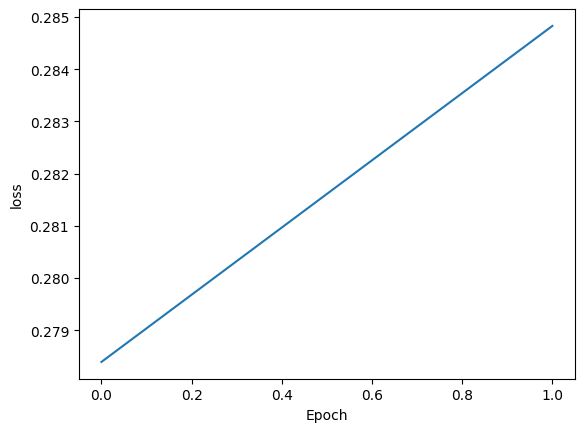

[ 5.344054  8.688793 -8.276486  0.256177]


0.5

In [19]:
import time
from qiskit import Aer, execute
#using gradient descent
eta=0.03
loss_list=[]
#Weight_list[][]

theta=np.ones(N)
#FedAvg-same scale
#theta=[2.1357003,1.1166838,0.0243824,0.378265575]     
#FedAvg- Scaled Up
#theta=[1.6869891, 0.2722195, -0.0349582, 0.2437433, 2.5844115, 1.9611481, 2.0593406, 0.51278785]
#FedAvg-Dynamic task selection
#Task Selection and Scheduling: Consider dynamic task selection and scheduling strategies to assign data samples to tasks 
#that need more attention. 
#By focusing on tasks that contribute more, the federated model is implemented.
#User Input : Underwater or Aerial Dataset? set theta accordingly.
    
print("Epoch \t Loss \t Training accuracy")
# Start the timer
start_time = time.time()
epoch = 2

for i in range(epoch):
    loss_func=[]
    for x_i,y_i in zip(x_train,y_train):
        prediction = quantum_nn(x_i,theta)
        loss_func.append(loss(prediction,y_i))
        #update theta
        theta=theta-eta*gradient(x_i,y_i,theta)
        
    loss_list.append(np.mean(loss_func))
    acc=accuracy(x_train,y_train,theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

end_time = time.time()

execution_time = end_time - start_time

# Print the execution time
print(f"Execution time: {execution_time} seconds")
#print("Early stopping at minimum loss")


plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

accuracy(x_test,y_test,theta)